## Trying to get self-supervised learning of angles working

Let's go back to basics, ignore the probabilistic stuff and just try to get a NN to learn the angles of MNIST digits. 

In [1]:
%load_ext autoreload
%autoreload 2

import os

os.environ["WANDB_NOTEBOOK_NAME"] = "selfsupervised.ipynb"

from typing import Union

from ml_collections import config_dict
import jax.random as random
import jax.numpy as jnp

jnp.log(jnp.exp(1) - 1.0)
# TODO: figure out why we get CUDA failures this ^ isn't here. 

from absl import logging

from src.utils.training import setup_model, get_dataset_splits, train_loop
import src.utils.input as input_utils
from src.models.common import ResNet18
from src.transformations import transform_image


# set save plot face color to be white
import matplotlib.pyplot as plt
plt.rcParams["savefig.facecolor"] = "white"

/var/home/jua23/.virtualenvs/inv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-08-14 10:59:21.260260: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/var/home/jua23/.virtualenvs/inv/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
logging.set_verbosity(logging.INFO)

In [3]:
rng = random.PRNGKey(0)
data_rng, model_rng = random.split(rng)

In [4]:
ANGLE = 180

dataset_config = config_dict.ConfigDict()
dataset_config.batch_size = 256
dataset_config.dataset = "MNIST"
dataset_config.shuffle_buffer_size = 50_000
dataset_config.repeat_after_batching = True  # NOTE: ordering of PP, shuffle, and repeat is important!
dataset_config.train_split = f"train[10000:]"
dataset_config.pp_train = f'value_range(-1, 1)|random_rotate(-{ANGLE}, {ANGLE}, fill_value=-1)|keep(["image"])'
dataset_config.val_split = f"train[:10000]"
dataset_config.pp_eval = f'value_range(-1, 1)|random_rotate(-{ANGLE}, {ANGLE}, fill_value=-1)|keep(["image", "label"])'


In [5]:
train_ds, val_ds, _ = get_dataset_splits(dataset_config, data_rng, dataset_config.batch_size, dataset_config.batch_size)

INFO:absl:Initializing train dataset...
INFO:absl:Load dataset info from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Fields info.[citation, splits, supervised_keys, module_name] from disk and from code do not match. Keeping the one from code.
INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='train[10000:]', index=0, count=1, drop_remainder=False), from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Features before preprocessing: {'image': 'uint8[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op ValueRange(vmin=-1, vmax=1, in_min=0, in_max=255.0, clip_values=False, key='image', key_result=None):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op RandomRotate(θ_min=-3.141592653589793, θ_max=3.141592653589793, fill_mode='nearest', fill_value=-1, key='image', key_result=None, rng_key='rng'):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:

In [6]:
from flax.training import train_state

import ciclo
import optax
import distrax

import jax
from jax import lax
import flax
import flax.linen as nn

from clu import parameter_overview

from typing import Any

from functools import partial

PRNGKey = Any

In [7]:
BOUNDS_ARRAY = jnp.array((0., 0., jnp.pi, 0., 0.))
NUM_CLASSES = 11

class MyModel(nn.Module):
    @nn.compact
    def __call__(self, x, train: bool = True):


        # # ResNet version
        # h = ResNet18(lowres=True, num_classes=64, num_filters=64)(x, train=train)



        # CNN version
        h = x

        for i, conv_dim in enumerate([128, 256, 512]):
            h = nn.Conv(
                conv_dim,
                kernel_size=(3, 3),
                strides=(2, 2) if i == 0 else (1, 1),
            )(h)
            h = nn.LayerNorm()(h)
            h = nn.relu(h)

        # ## Fully-conv version
        # h = nn.Conv(BOUNDS_ARRAY.shape[0], kernel_size=(3, 3), strides=(1, 1))(h)
        # features = jnp.mean(h, axis=(0, 1))
        
        # features = jax.nn.tanh(features)
        # return features * BOUNDS_ARRAY


        ## Standard version 
        h = nn.Conv(3, kernel_size=(3, 3), strides=(1, 1))(h)

        h = h.flatten()

        for dense_dim in [256, 128]:
            h = nn.Dense(dense_dim)(h)
            h = nn.LayerNorm()(h)
            h = nn.relu(h)
            h = nn.Dropout(rate=0.1, deterministic=not train)(h)



        # Regression version
        features = nn.Dense(BOUNDS_ARRAY.shape[0],
                            kernel_init=nn.initializers.zeros_init())(h)

        features = jax.nn.tanh(features)
        return features * BOUNDS_ARRAY

        # # Classification version
        # features = nn.Dense(BOUNDS_ARRAY.shape[0] * NUM_CLASSES)(h)
        # features = features.reshape((NUM_CLASSES, BOUNDS_ARRAY.shape[0]))
        # features = jax.nn.softmax(features, axis=0)
        # values = jnp.linspace(-BOUNDS_ARRAY, BOUNDS_ARRAY, NUM_CLASSES)
        
        # return jnp.sum(features * values, axis=0)

model = MyModel()

In [8]:
TOTAL_STEPS = 10_000
LR = 3e-4

In [9]:
variables = model.init(model_rng, jnp.empty((28, 28, 1)), train=False)

lr_schedule = optax.warmup_cosine_decay_schedule(LR, LR*3, TOTAL_STEPS//2, TOTAL_STEPS, end_value=LR//3)

class TrainState(train_state.TrainState):
    λ: float
    λ_schedule: optax.Schedule = flax.struct.field(pytree_node=False)

    def apply_gradients(self, *, grads, **kwargs):
        updates, new_opt_state = self.tx.update(grads, self.opt_state, self.params)
        new_params = optax.apply_updates(self.params, updates)
        return self.replace(
            step=self.step + 1,
            params=new_params,
            opt_state=new_opt_state,
            λ=self.λ_schedule(self.step),
            **kwargs,
        )

    @classmethod
    def create(
        cls,
        *,
        apply_fn,
        params,
        tx,
        λ_schedule,
        **kwargs,
    ):
        opt_state = tx.init(params)
        return cls(
            step=0,
            apply_fn=apply_fn,
            params=params,
            tx=tx,
            opt_state=opt_state,
            λ_schedule=λ_schedule,
            λ=λ_schedule(0),
            **kwargs,
        )

state = TrainState.create(
    apply_fn=model.apply,
    params=variables["params"],
    tx=optax.adamw(lr_schedule),
    λ_schedule=optax.cosine_decay_schedule(3, TOTAL_STEPS, 1)
)

In [10]:
parameter_overview.log_parameter_overview(variables)

INFO:absl:
+--------------------------+------------------+-----------+-----------+--------+
| Name                     | Shape            | Size      | Mean      | Std    |
+--------------------------+------------------+-----------+-----------+--------+
| params/Conv_0/bias       | (128,)           | 128       | 0.0       | 0.0    |
| params/Conv_0/kernel     | (3, 3, 1, 128)   | 1,152     | 0.00243   | 0.331  |
| params/Conv_1/bias       | (256,)           | 256       | 0.0       | 0.0    |
| params/Conv_1/kernel     | (3, 3, 128, 256) | 294,912   | -1.66e-05 | 0.0295 |
| params/Conv_2/bias       | (512,)           | 512       | 0.0       | 0.0    |
| params/Conv_2/kernel     | (3, 3, 256, 512) | 1,179,648 | 1.39e-05  | 0.0208 |
| params/Conv_3/bias       | (3,)             | 3         | 0.0       | 0.0    |
| params/Conv_3/kernel     | (3, 3, 512, 3)   | 13,824    | 0.000216  | 0.0146 |
| params/Dense_0/bias      | (256,)           | 256       | 0.0       | 0.0    |
| params/Dense_0/

In [11]:
def loss_fn(x, params, state, step_rng, n_samples):
    rng_local = random.fold_in(step_rng, lax.axis_index("batch"))
    rng_dropout, rng_η = random.split(rng_local)

    η_x = state.apply_fn({"params": params}, x, rngs={"dropout": rng_dropout})
    x_hat = transform_image(x, -η_x)

    Η_rand = distrax.Uniform(low=-BOUNDS_ARRAY, high=BOUNDS_ARRAY)
    η_rands = Η_rand.sample(seed=rng_η, sample_shape=(n_samples,))
    x_rands = jax.vmap(transform_image, in_axes=(None, 0))(x, η_rands)

    η_x_rands = jax.vmap(
        lambda x_: state.apply_fn({"params": params}, x_, rngs={"dropout": rng_dropout})
    )(x_rands)
    x_recons = jax.vmap(transform_image, in_axes=(None, 0))(x, η_x_rands - η_x)
    # x_recons = jax.vmap(transform_image, in_axes=(None, 0))(x_hat, η_x_rands)

    # var = jnp.var(η_x_rands, axis=0).mean()
    var = jnp.var(x_recons, axis=0).mean()

    mse = jnp.mean((x - x_recons) ** 2)

    loss = mse - state.λ*var
    return loss, {'mse': mse, 'var': var}


@jax.jit
def train_step(state: TrainState, batch):
    step_rng = random.fold_in(rng, state.step)

    def batch_loss_fn(params):
        loss, metrics = jax.vmap(loss_fn, in_axes=(0, None, None, None, None), axis_name="batch")(
            batch["image"][0], params, state, step_rng, 5
        )
        loss, metrics = jax.tree_map(lambda x: x.mean(), (loss, metrics))
        return loss, metrics

    (loss, metrics), grads = jax.value_and_grad(batch_loss_fn, has_aux=True)(state.params)
    new_state = state.apply_gradients(grads=grads)

    logs = ciclo.logs()
    logs.add_metric("loss", loss)
    for k, v in metrics.items():
        logs.add_metric(k, v)

    return logs, new_state


@jax.jit
def test_step(state, batch):
    step_rng = random.fold_in(rng, state.step)

    def batch_loss_fn(params):
        loss, metrics = jax.vmap(loss_fn, in_axes=(0, None, None, None, None), axis_name="batch")(
            batch["image"][0], params, state, step_rng, 1
        )
        loss, metrics = jax.tree_map(lambda x: x.mean(), (loss, metrics))
        return loss, metrics

    loss, metrics = batch_loss_fn(state.params)

    logs = ciclo.logs()
    logs.add_metric("loss", loss)
    for k, v in metrics.items():
        logs.add_metric(k, v)

    return logs, state

In [12]:
state, history, _ = ciclo.train_loop(
    state,
    input_utils.start_input_pipeline(train_ds, 2),
    {
        ciclo.on_train_step: train_step,
        ciclo.on_test_step: test_step,
    },
    test_dataset=lambda: input_utils.start_input_pipeline(val_ds, 2),
    epoch_duration=TOTAL_STEPS // 100,
    callbacks=[
        ciclo.keras_bar(total=TOTAL_STEPS),
    ],
    stop=TOTAL_STEPS,
)

 9999/10000 [============================>.] - ETA: 0s - loss: -0.0621 - mse: 0.3598 - var: 0.1407 - loss_test: 0.1348 - mse_test: 0.1348 - var_test: 0.0000e+0000000              - ETA: 30:54:07 - loss: 0.0543 - mse: 0.0551 - var: 2.5313e-04 - loss_test: 0.0000e+00 - mse_test: 0.0000e+00 - var_test: 0.0000e+ - ETA: 18:39:14 - loss: 0.0523 - mse: 0.0574 - var: 0.0017 - loss_test: 0.0000e+00 - mse_test: 0.0000e+00 - var_test: 0.0000e+ - ETA: 13:24:12 - loss: 0.0484 - mse: 0.0645 - var: 0.0054 - loss_test: 0.0000e+00 - mse_test: 0.0000e+00 - var_test: 0.0000e+ - ETA: 10:29:11 - loss: 0.0433 - mse: 0.0748 - var: 0.0105 - loss_test: 0.0000e+00 - mse_test: 0.0000e+00 - var_test: 0.0000e - ETA: 8:37:47 - loss: 0.0372 - mse: 0.0889 - var: 0.0172 - loss_test: 0.0000e+00 - mse_test: 0.0000e+00 - var_test: 0.0000 - ETA: 7:20:46 - loss: 0.0315 - mse: 0.1062 - var: 0.0249 - loss_test: 0.0000e+00 - mse_test: 0.0000e+00 - var_test: 0.0000 - ETA: 6:24:16 - loss: 0.0259 - mse: 0.1229 - var: 0.0323 - lo

/var/home/jua23/.virtualenvs/inv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  fig.canvas.print_figure(bytes_io, **kw)


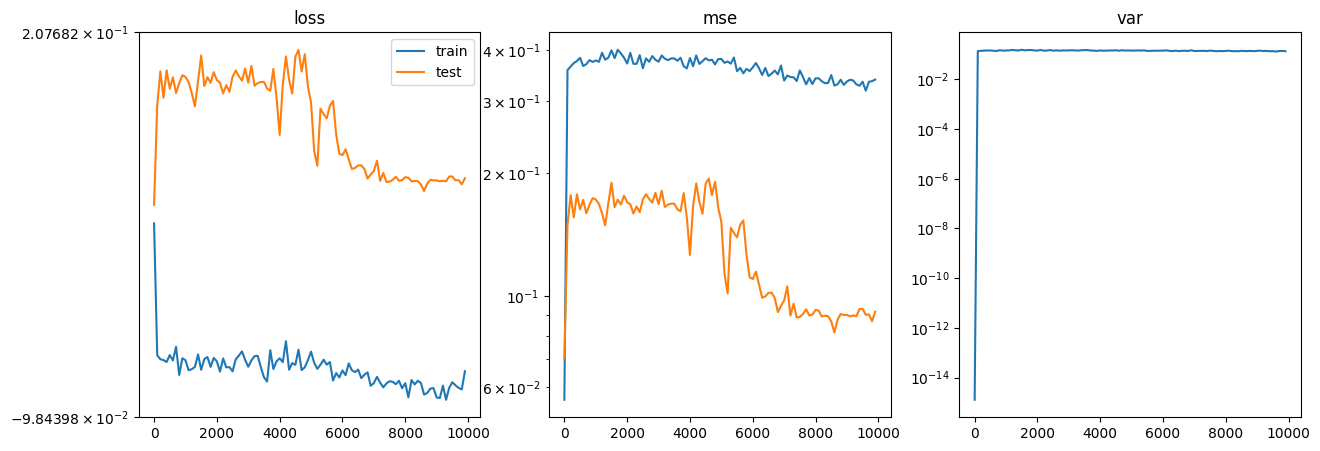

In [13]:
# plot the training history
steps, loss, loss_test, mse, mse_test, var, var_test = history.collect(
    "steps", "loss", "loss_test", "mse", "mse_test", "var", "var_test"
)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].plot(steps, loss, label="train")
axs[0].plot(steps, loss_test, label="test")
axs[0].legend()
axs[0].set_title("loss")
axs[0].set_yscale("symlog")

axs[1].plot(steps, mse, label="train")
axs[1].plot(steps, mse_test, label="test")
# axs[1].legend()
axs[1].set_title("mse")
axs[1].set_yscale("log")

axs[2].plot(steps, var, label="train")
axs[2].plot(steps, var_test, label="test")
# axs[2].legend()
axs[2].set_title("var")
axs[2].set_yscale("log")

plt.show()

In [14]:
val_iter = input_utils.start_input_pipeline(val_ds, 1)
val_batch = next(val_iter)

trn_iter = input_utils.start_input_pipeline(train_ds, 1)
trn_batch = next(trn_iter)

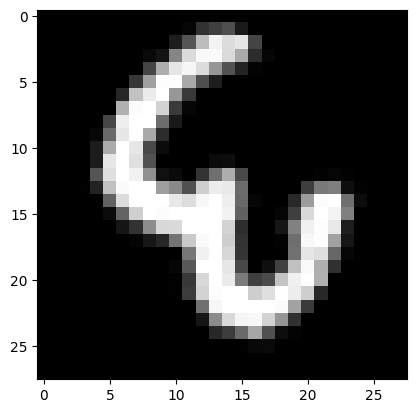

In [19]:
x = val_batch['image'][0][14]

plt.imshow(x, cmap='gray')

In [20]:
[η for η in distrax.Uniform(low=-BOUNDS_ARRAY, high=BOUNDS_ARRAY).sample(seed=rng, sample_shape=(13,))]

[Array([0.        , 0.        , 0.33589697, 0.        , 0.        ],      dtype=float32),
 Array([ 0.        ,  0.        , -0.57685256,  0.        ,  0.        ],      dtype=float32),
 Array([ 0.       ,  0.       , -2.9686978,  0.       ,  0.       ],      dtype=float32),
 Array([0.       , 0.       , 1.1887429, 0.       , 0.       ], dtype=float32),
 Array([0.       , 0.       , 1.7569902, 0.       , 0.       ], dtype=float32),
 Array([0.       , 0.       , 2.2007487, 0.       , 0.       ], dtype=float32),
 Array([ 0.       ,  0.       , -0.7210834,  0.       ,  0.       ],      dtype=float32),
 Array([ 0.        ,  0.        , -0.45290923,  0.        ,  0.        ],      dtype=float32),
 Array([ 0.      ,  0.      , -2.233971,  0.      ,  0.      ], dtype=float32),
 Array([ 0.       ,  0.       , -2.6235087,  0.       ,  0.       ],      dtype=float32),
 Array([ 0.       ,  0.       , -2.6555471,  0.       ,  0.       ],      dtype=float32),
 Array([0.       , 0.       , 1.8190773,

In [21]:
# transformed_xs = [transform_image(x, jnp.array([0., 0., angle * jnp.pi / 180, 0., 0.])) for angle in jnp.arange(0., 361, 30)]
transformed_xs = [
    transform_image(x, η) for η in distrax.Uniform(low=-BOUNDS_ARRAY, high=BOUNDS_ARRAY).sample(seed=rng, sample_shape=(13,))
]

# TODO: now run this to see if we can learn protos in the non-rotation case
def get_proto(x):
    η = state.apply_fn({"params": state.params}, x, train=False)
    xhat = transform_image(x, -η)
    return xhat, η

xhats, ηs = zip(*[get_proto(x) for x in transformed_xs])
[η[2] for η in ηs]

[Array(-0.00490707, dtype=float32),
 Array(-0.3367199, dtype=float32),
 Array(1.5750289, dtype=float32),
 Array(0.42587596, dtype=float32),
 Array(-2.310926, dtype=float32),
 Array(-1.1565937, dtype=float32),
 Array(-0.36812544, dtype=float32),
 Array(-0.28394938, dtype=float32),
 Array(2.4504516, dtype=float32),
 Array(2.075359, dtype=float32),
 Array(2.0400326, dtype=float32),
 Array(-2.2130065, dtype=float32),
 Array(-0.47967157, dtype=float32)]

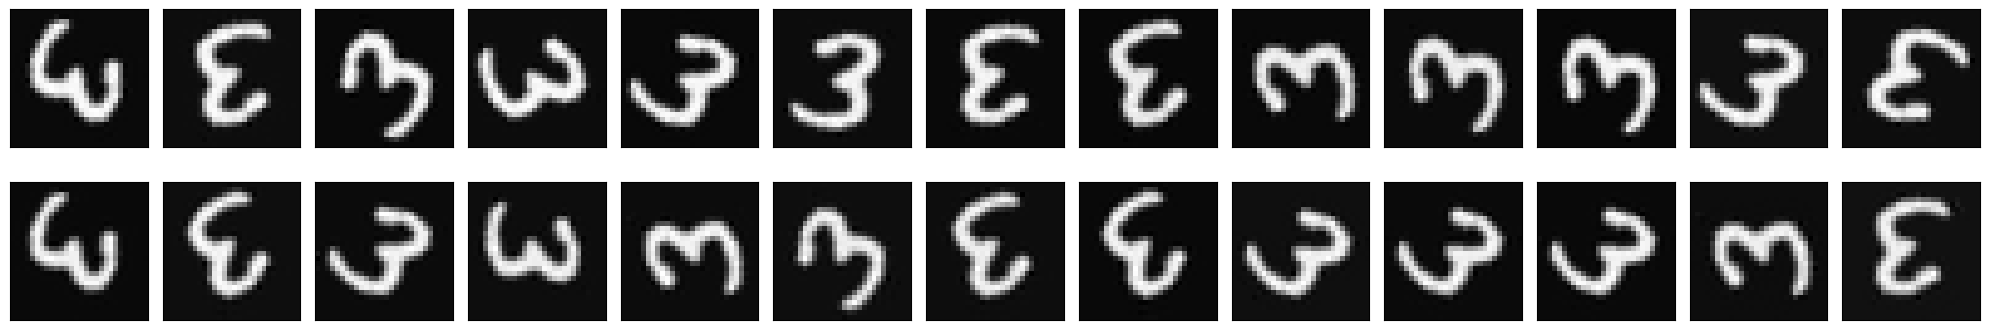

In [22]:
fig, axs = plt.subplots(2, len(xhats), figsize=(20, 4))

for ax, x in zip(axs[0], transformed_xs):
    ax.imshow(x, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

for ax, xhat in zip(axs[1], xhats):
    ax.imshow(xhat, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()